In [240]:
!pip install scikit-posthocs

In [241]:
import DCDSFunctions as f
import pandas as pd
import numpy as np
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import scikit_posthocs as ph

In [266]:
h1b1 = pd.read_csv('data/cleaned_for_testing.csv')

In [267]:
h1b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9028 entries, 0 to 9027
Data columns (total 10 columns):
Company       9028 non-null object
Location      9028 non-null object
Role          9028 non-null object
Salary        9028 non-null int64
StartDate     9028 non-null object
Status        9028 non-null object
SubmitDate    9028 non-null object
Year          9028 non-null int64
Region        9028 non-null object
Industry      9028 non-null object
dtypes: int64(2), object(8)
memory usage: 705.4+ KB


In [268]:
h1b1.describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,9028.0,108208.093930,29583.272983,5769.0,85738.0,105000.0,127011.5,312000.0
Year,9028.0,2017.600798,1.283519,2014.0,2017.0,2018.0,2019.0,2019.0


In [269]:
# comparing accross more than two years is problematic so lets see when the bulk of our data comes from
h1b1.groupby('Year')['Salary'].nunique().sort_values(ascending=False)

Year
2018    808
2019    764
2017    525
2016    365
2015    233
2014     51
Name: Salary, dtype: int64

In [270]:
years = list(h1b1.Year.unique())
years

[2014, 2015, 2016, 2017, 2018, 2019]

In [271]:
def slice_by_year(df, year):
    slice_df = df[df['Year'] == year]
    return slice_df

In [272]:
for year in years:
    print(year)
    display(slice_by_year(h1b1, year).describe().T)

2014


,count,mean,std,min,25%,50%,75%,max
Salary,83.0,121389.349398,23946.680923,64210.0,105000.0,120000.0,137286.5,175000.0
Year,83.0,2014.000000,0.000000,2014.0,2014.0,2014.0,2014.0,2014.0


2015


,count,mean,std,min,25%,50%,75%,max
Salary,677.0,108270.444609,26786.393004,5769.0,90000.0,110000.0,125000.0,205000.0
Year,677.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0


2016


,count,mean,std,min,25%,50%,75%,max
Salary,1144.0,105585.597028,27774.521628,29973.0,85000.0,105000.0,124425.25,250000.0
Year,1144.0,2016.000000,0.000000,2016.0,2016.0,2016.0,2016.00,2016.0


2017


,count,mean,std,min,25%,50%,75%,max
Salary,1633.0,108316.644825,29273.680896,37482.0,86466.0,105934.0,127000.0,253630.0
Year,1633.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0


2018


,count,mean,std,min,25%,50%,75%,max
Salary,2811.0,110799.220206,31729.663787,43056.0,87000.0,108000.0,130000.0,312000.0
Year,2811.0,2018.000000,0.000000,2018.0,2018.0,2018.0,2018.0,2018.0


2019


,count,mean,std,min,25%,50%,75%,max
Salary,2680.0,106119.646642,28695.165149,41246.0,85000.0,100000.0,125000.0,231000.0
Year,2680.0,2019.000000,0.000000,2019.0,2019.0,2019.0,2019.0,2019.0


## 6 ANOVA Assumptions
1. "The dependent variable should be measured at the continuous level (i.e., it is an interval or ratio variable)."
2. "Your three independent variables should each consist of two or more categorical, independent groups"
3. "You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves"
4. "There should be no significant outliers"
5. "Your dependent variable should be approximately normally distributed for each combination of the groups of the three independent variables" (Shapiro-Wilk test)
6. "Homogeneity of variances for each combination of the groups of the three independent variables" Levene's test

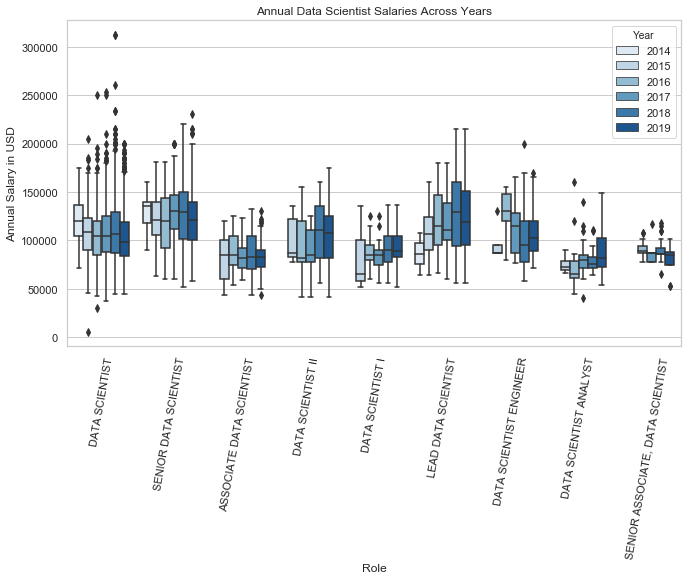

In [261]:
# Let's visually check the distribution of our dependent variable accross experience
sns.set(style="whitegrid")
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)
ax = sns.boxplot(x=h1b1["Role"],
                 y=h1b1['Salary'], hue=h1b1['Year'], palette='Blues')
plt.xticks(rotation=80)
plt.ylabel("Annual Salary in USD")
plt.title("Annual Data Scientist Salaries Across Years")
plt.show()

In [273]:
before_drop = len(h1b1)
h1b1 = h1b1[h1b1['Salary']>40000]# three values, likely typos or atypical contracts
h1b1 = h1b1[h1b1['Salary']<300000] # two values, larson living labs
h1b1 = h1b1.drop_duplicates()# several repeat entries
print(str(round(before_drop/len(h1b1)*100, 1)) + '%')

105.7%


In [274]:
h1b1.groupby('Role')['Salary'].nunique().sort_values(ascending=False)[0:5]

Role
DATA SCIENTIST              1480
SENIOR DATA SCIENTIST        458
DATA SCIENTIST II            119
ASSOCIATE DATA SCIENTIST     118
LEAD DATA SCIENTIST           94
Name: Salary, dtype: int64

In [278]:
for year in years:
    print(year)
    print(slice_by_year(h1b1, year).groupby('Role')['Salary'].nunique().sort_values(ascending=False)[0:5], "\n")

2014
Role
DATA SCIENTIST           44
SENIOR DATA SCIENTIST    11
LEAD DATA SCIENTIST       2
Name: Salary, dtype: int64 

2015
Role
DATA SCIENTIST              186
SENIOR DATA SCIENTIST        53
ASSOCIATE DATA SCIENTIST     12
LEAD DATA SCIENTIST           8
DATA SCIENTIST II             7
Name: Salary, dtype: int64 

2016
Role
DATA SCIENTIST              280
SENIOR DATA SCIENTIST        83
ASSOCIATE DATA SCIENTIST     22
LEAD DATA SCIENTIST          17
DATA SCIENTIST II            17
Name: Salary, dtype: int64 

2017
Role
DATA SCIENTIST              410
SENIOR DATA SCIENTIST       119
ASSOCIATE DATA SCIENTIST     30
LEAD DATA SCIENTIST          25
DATA SCIENTIST II            21
Name: Salary, dtype: int64 

2018
Role
DATA SCIENTIST              613
SENIOR DATA SCIENTIST       199
DATA SCIENTIST II            47
LEAD DATA SCIENTIST          40
ASSOCIATE DATA SCIENTIST     38
Name: Salary, dtype: int64 

2019
Role
DATA SCIENTIST              471
SENIOR DATA SCIENTIST       198
DATA SC

Given the size let's take the top 4 values in the top 3 years

In [279]:
data_scientists = h1b1[h1b1['Role'] == 'DATA SCIENTIST']
senior_data_scientists = h1b1[h1b1['Role'] == 'SENIOR DATA SCIENTIST']
lead_data_scientists = h1b1[h1b1['Role'] == 'LEAD DATA SCIENTIST']
associate_data_scientists = h1b1[h1b1['Role'] == 'ASSOCIATE DATA SCIENTIST']

In [311]:
h1b1 = pd.concat([data_scientists, senior_data_scientists, lead_data_scientists, associate_data_scientists]) 
len(h1b1)

7763

In [283]:
# h1b1_2014 = slice_by_year(h1b1, 2014)
# h1b1_2015 = slice_by_year(h1b1, 2015)
# h1b1_2016 = slice_by_year(h1b1, 2016)
# h1b1_2017 = slice_by_year(h1b1, 2017)
# h1b1_2018 = slice_by_year(h1b1, 2018)
# h1b1_2019 = slice_by_year(h1b1, 2019)

In [284]:
# # set([x for x in slice_by_year(h1b1,year)])
# roles_2017 = list(set([x for x in h1b1_2017.Role]))
# for role in roles_2017:
#     shapiro_test = stats.shapiro(h1b1_2017[h1b1_2017['Role'] == role]["Salary"])
#     p_value = shapiro_test[1]
#     if p_value > 0.05:
#         print(f"{role}: p-value={p_value}, SATISFIES #5.")
#     else:
#         print(f"{role}: p-value={p_value}, DOES NOT satisfy #5.")

In [285]:
# stats.shapiro(h1b1_2014[h1b1_2014['Role'] == 'SENIOR DATA SCIENTIST']["Salary"])

Let's do a one-way ANOVA for two of our largest, complete years

In [312]:
years_2017_2018_2019 = [2017, 2018, 2019]

In [313]:
for year in years_2017_2018_2019:
    print(f"Oneway ANOVA test for {year}")
    h1b1_year = slice_by_year(h1b1,year)
    formula = 'Salary ~ C(Role)'
    lm = ols(formula, h1b1_year).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table, "\n")
    shapiro_test = stats.shapiro(lm.resid)
    p_value = shapiro_test[1]
    print(f"Shapiro-Wilk test")
    if p_value > 0.05:
        print(f"{year}: p-value={p_value}, SATISFIES #5.")
    else:
        print(f"{year}: p-value={p_value}, DOES NOT satisfy #5.")
    print("------------\n")
#     roles = list(set([x for x in h1b1_year.Role]))
#     for role in roles:
#         shapiro_test = stats.shapiro(lm.resid)
#         p_value = shapiro_test[1]
#         if p_value > 0.05:
#             print(f"{role}: p-value={p_value}, SATISFIES #5.")
#         else:
#             print(f"{role}: p-value={p_value}, DOES NOT satisfy #5.")

Oneway ANOVA test for 2017
                sum_sq      df          F        PR(>F)
C(Role)   1.346964e+11     3.0  59.519345  2.674445e-36
Residual  1.100606e+12  1459.0        NaN           NaN 

Shapiro-Wilk test
2017: p-value=3.5938610420949146e-10, DOES NOT satisfy #5.
------------

Oneway ANOVA test for 2018
                sum_sq      df          F        PR(>F)
C(Role)   1.643107e+11     3.0  59.086773  7.559270e-37
Residual  2.221890e+12  2397.0        NaN           NaN 

Shapiro-Wilk test
2018: p-value=9.144551816689665e-17, DOES NOT satisfy #5.
------------

Oneway ANOVA test for 2019
                sum_sq      df          F        PR(>F)
C(Role)   2.062370e+11     3.0  90.273139  5.116261e-55
Residual  1.635765e+12  2148.0        NaN           NaN 

Shapiro-Wilk test
2019: p-value=8.169802865281183e-19, DOES NOT satisfy #5.
------------



In [62]:
# senior_ds = h1b1[h1b1['Role'] == 'SENIOR DATA SCIENTIST']
# senior_ds.head()

In [63]:
# just_ds = h1b1[h1b1['Role'] == 'DATA SCIENTIST']
# just_ds.head()

In [64]:
# print(len(senior_ds))
# print(len(just_ds))
# print(len(senior_ds) + len(just_ds))

In [65]:
# senior_and_just_ds = pd.concat([senior_ds, just_ds])
# senior_and_just_ds.head()

In [66]:
# len(senior_and_just_ds)

In [218]:
# for year in years:
#     print(f"Tukey post-hoc test for {year}")
#     print(pairwise_tukeyhsd(slice_by_year(h1b1, year).Salary, slice_by_year(h1b1, year).Role, alpha=0.05))

So our ANOVA in both years fails the 5th assumption (not surprising since it's not a random sample)...on to non-parametric tests!

In [294]:
for year in years_2017_2018:
    roles = list(set([x for x in slice_by_year(h1b1, year).Role]))
    combos = list(itertools.combinations(roles, 2))
    h1b1_year = slice_by_year(h1b1,year)
    stat, p = stats.kruskal(h1b1_year[h1b1_year['Role'] == roles[0]].Salary,
                            h1b1_year[h1b1_year['Role'] == roles[1]].Salary, 
                            h1b1_year[h1b1_year['Role'] == roles[2]].Salary,
                            h1b1_year[h1b1_year['Role'] == roles[3]].Salary) 
#                             h1b1_year[h1b1_year['Role'] == roles[4]].Salary, 
#                             h1b1_year[h1b1_year['Role'] == roles[5]].Salary, 
#                             h1b1_year[h1b1_year['Role'] == roles[6]].Salary, 
#                             h1b1_year[h1b1_year['Role'] == roles[7]].Salary, 
#                             h1b1_year[h1b1_year['Role'] == roles[8]].Salary)
    print(f"Kruskal-Wallis Test results for {year}'s data:")
    print('Statistics = %.3f, p = %.2f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0) \n')
    else:
        print('Different distributions (reject H0) \n')

Kruskal-Wallis Test results for 2017's data:
Statistics = 162.000, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2018's data:
Statistics = 167.971, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2019's data:
Statistics = 235.676, p = 0.00
Different distributions (reject H0) 



In [299]:
df = ph.posthoc_conover(slice_by_year(h1b1,2017), val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.000
DATA SCIENTIST,0.0,-1.000,0.038,0.000
LEAD DATA SCIENTIST,0.0,0.038,-1.000,0.038
SENIOR DATA SCIENTIST,0.0,0.000,0.038,-1.000


All combinations in our non-random sample fall below alpha so we can reject the null hypothesis: data science salaries for foreigners did differ significantly based on title (and by proxy, experience).

In [300]:
# let's try 2018
df = ph.posthoc_conover(slice_by_year(h1b1,2018), val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.00
DATA SCIENTIST,0.0,-1.000,0.008,0.00
LEAD DATA SCIENTIST,0.0,0.008,-1.000,0.21
SENIOR DATA SCIENTIST,0.0,0.000,0.210,-1.00


It looks like the difference between lead data scientists' and senior data scientists' salaries is not longer significant. Let's highlight that.

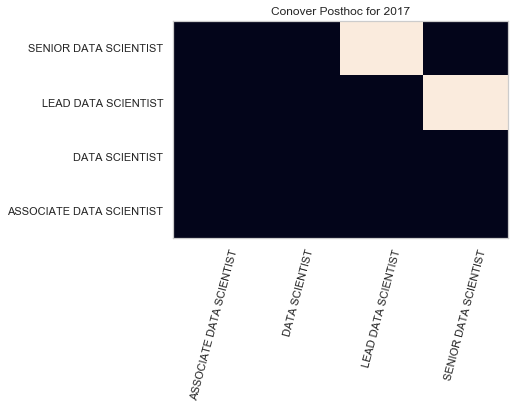

In [304]:
plt.pcolor(df, vmin=alpha)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation= 75)
plt.title("Conover Posthoc for 2017")
plt.show()

In [309]:
# Our guess is that this convergence continues in the first-third of 2019
df = ph.posthoc_conover(slice_by_year(h1b1,2019), val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.0,0.000,0.000
DATA SCIENTIST,0.0,-1.0,0.000,0.000
LEAD DATA SCIENTIST,0.0,0.0,-1.000,0.346
SENIOR DATA SCIENTIST,0.0,0.0,0.346,-1.000


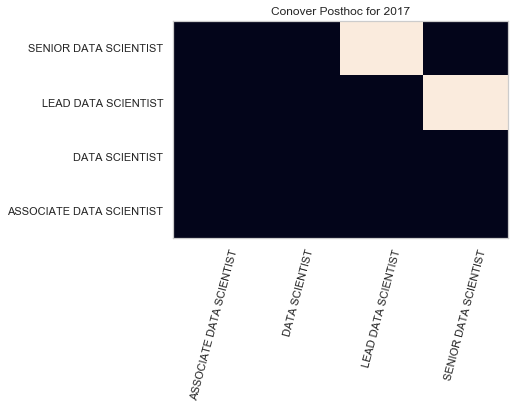

In [314]:
plt.pcolor(df, vmin=alpha)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation= 75)
plt.title("Conover Posthoc for 2017")
plt.show()

In [ ]:
# still need to test for heteroskedasticity though hopefully the years selection took care of this.